<img src="img/header1.png"></img>

<h1 style="text-align: left;">ToT: PySpark Basics to Inter./Adv. in ± 15 Minutes</h1>
By: Imam Cholissodin | Dosen Fakultas Ilmu Komputer (FILKOM), Universitas Brawijaya (UB)

# **PySpark Streaming**: getTweetStreaming untuk Analisis Tren secara Real Time

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("pyspark-stream-hist").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "512m").\
        getOrCreate()

sc = spark.sparkContext

In [3]:
#!pip install matplotlib
#!pip install seaborn

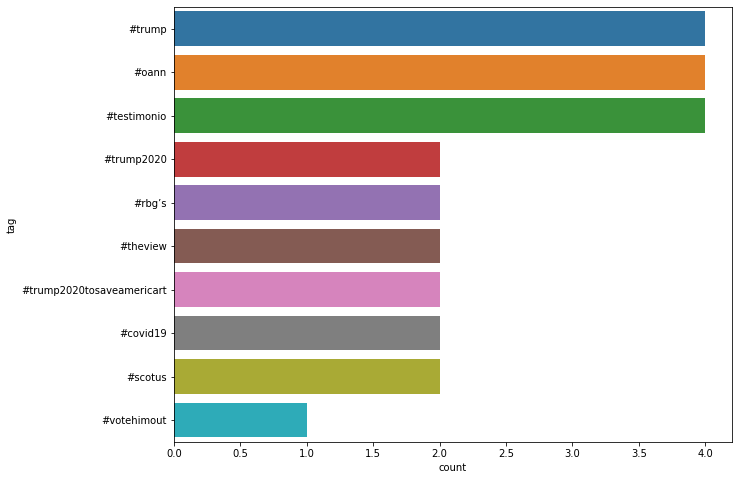

In [4]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SQLContext
from pyspark.sql.functions import desc

# Not required if running in Pyspark integrated notebooksc = SparkContext()

sc.setLogLevel('ERROR')
# ssc = spark streaming context dengan interval waktu proses 10 detik
ssc = StreamingContext(sc, 10)
sqlContext = SQLContext(sc)

# set untuk client pada socketStream
socket_stream = ssc.socketTextStream("54.208.1.149",8501)

lines = socket_stream.window(20)

from collections import namedtuple
fields = ("tag","count")
Tweet = namedtuple('Tweet', fields)

# use () for multiple lines
(lines.flatMap(lambda text: text.split(" "))
.filter(lambda word: word.startswith("#"))
.map(lambda word: (word.lower(), 1))
.reduceByKey(lambda a, b : a + b)
.map(lambda rec: Tweet(rec[0],rec[1]))
.foreachRDD(lambda rdd: rdd.toDF().sort(desc("count"))
.limit(10).registerTempTable("tweets")))


import time
from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
# get_ipython().run_line_magic('matplotlib', 'inline')

ssc.start()

count = 0
while count < 10:
    time.sleep(10)
    top_10_tweets = sqlContext.sql("select tag,count from tweets")
    top_10_df = top_10_tweets.toPandas()
    display.clear_output(wait = True)
    plt.figure(figsize= (10, 8))
    sns.barplot(x="count", y="tag",data=top_10_df)
    plt.show()
    count = count+1
ssc.stop()